In [1]:
import numpy as np
import cv2
import os, os.path
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')
# tf.config.run_functions_eagerly(True)
folder = "E:\BTP\SOCOFing\Test"
# folder = "/content/Fingerprint"

In [2]:
def create_model():
    inputs = Input((103, 96, 1))
    x = Conv2D(100, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

In [3]:
feature_extractor = create_model()
imgA = Input(shape=(103, 96, 1))
imgB = Input(shape=(103, 96, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [5]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
def generate_train_image_pairs():    
    pair_images = []
    pair_labels = []
    for index, image_name in enumerate(os.listdir(folder)):
        
        image = cv2.imread(os.path.join(folder, image_name), 0)
        img = np.expand_dims(image, axis=2)
        height, width = image.shape[:2]
        center = (width/2, height/2)
        
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(360), scale=1)
        pos_rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
        pos_rotated_image = np.expand_dims(pos_rotated_image, axis=2)
        for temp in range(10):
            rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(360), scale=1)
            pos_rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
            pos_rotated_image = np.expand_dims(pos_rotated_image, axis=2)
            pair_images.append((img, pos_rotated_image))
            pair_labels.append(1)
            
            name=image_name
            while name==image_name:
                name = np.random.choice(os.listdir(folder))
            neg_image = cv2.imread(os.path.join(folder, name), 0)
            rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(360), scale=1)
            neg_image = cv2.warpAffine(src=neg_image, M=rotate_matrix, dsize=(width, height))
            neg_image = np.expand_dims(neg_image, axis=2)
            pair_images.append((img, neg_image))
            pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

In [7]:
images_pair, labels_pair = generate_train_image_pairs()

In [8]:
!mkdir tmp
checkpoint_filepath = '/tmp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_freq="epoch", verbose=1)

A subdirectory or file tmp already exists.


In [9]:
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:],validation_split=0.1,batch_size=60,epochs=100
                    , callbacks=[model_checkpoint_callback])

Train on 1080 samples, validate on 120 samples
Epoch 1/100
1020/1080 [===========================>..] - ETA: 6s - loss: 1.7982 - acc: 0.5049 
Epoch 00001: saving model to /tmp
1080/1080 [==============================] - 113s 105ms/sample - loss: 1.7370 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.5083
Epoch 2/100
1020/1080 [===========================>..] - ETA: 6s - loss: 0.6935 - acc: 0.4980 
Epoch 00002: saving model to /tmp
1080/1080 [==============================] - 115s 107ms/sample - loss: 0.6935 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4833
Epoch 3/100
1020/1080 [===========================>..] - ETA: 6s - loss: 0.6935 - acc: 0.4990 
Epoch 00003: saving model to /tmp
1080/1080 [==============================] - 116s 107ms/sample - loss: 0.6935 - acc: 0.5000 - val_loss: 0.6935 - val_acc: 0.4417
Epoch 4/100
1020/1080 [===========================>..] - ETA: 5s - loss: 0.6946 - acc: 0.5029 
Epoch 00004: saving model to /tmp
1080/1080 [==============================] - 108s 

In [10]:
images_pair.shape

(1200, 2, 103, 96, 1)

In [11]:
!mkdir siamese_model
model.save('siamese_model/first_model')

A subdirectory or file siamese_model already exists.


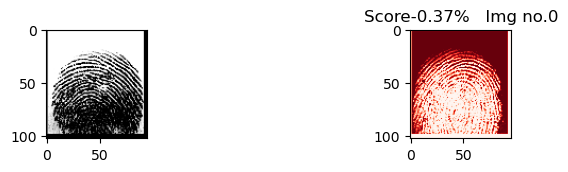

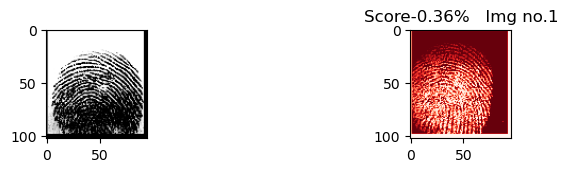

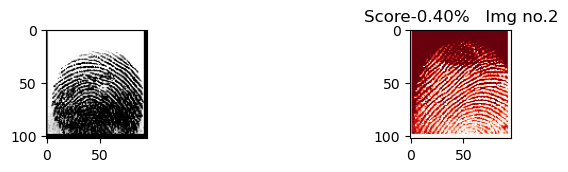

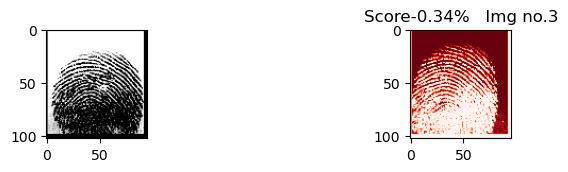

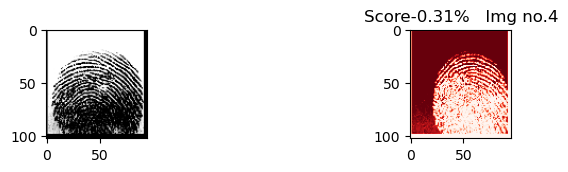

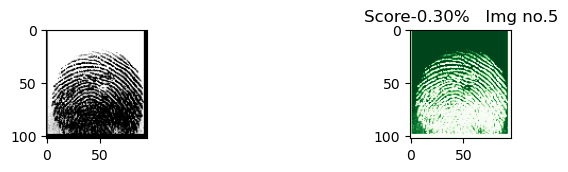

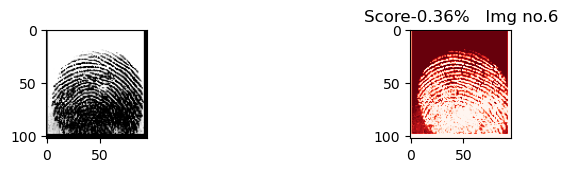

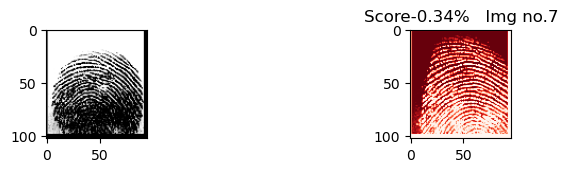

In [12]:
# a random image as test image
# rnd_image = cv2.imread(os.path.join(folder,np.random.choice(os.listdir(folder))))
rnd_image = cv2.imread(os.path.join(folder, os.listdir(folder)[57]), 0)
rnd_image_clr = cv2.imread(os.path.join(folder, os.listdir(folder)[57]))
pair_image1 = np.expand_dims(rnd_image, axis=-1)
pair_image1 = np.expand_dims(pair_image1, axis=0)

for index, name in enumerate(os.listdir(folder)[52:]):
    test_img = cv2.imread(os.path.join(folder, name), 0)
    test_img_clr = cv2.imread(os.path.join(folder, name))
    pair_image2 = np.expand_dims(test_img, axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    
    if name==os.listdir(folder)[57]: 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
    
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
    plt.imshow(rnd_image_clr ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(prediction)+str(index))
    plt.imshow(cv2.cvtColor(test_img_clr, cv2.COLOR_BGR2GRAY),cmap=c_map)

In [13]:
pair_image2.shape

(1, 103, 96, 1)

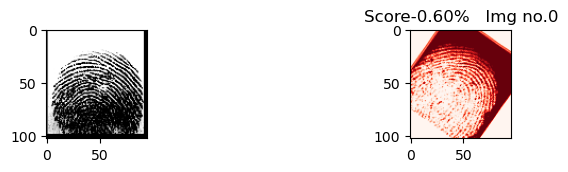

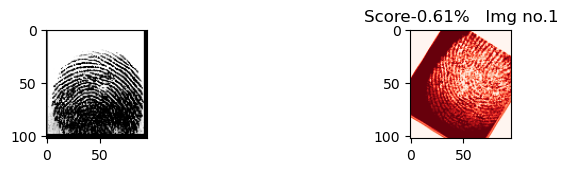

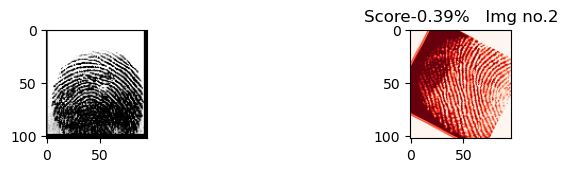

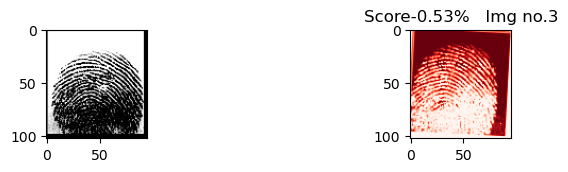

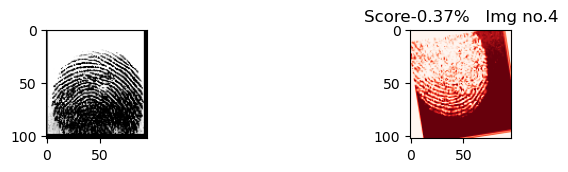

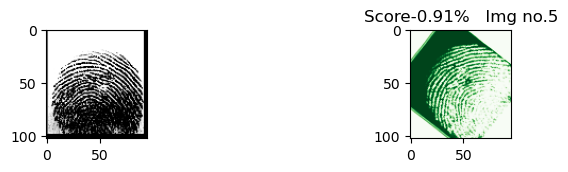

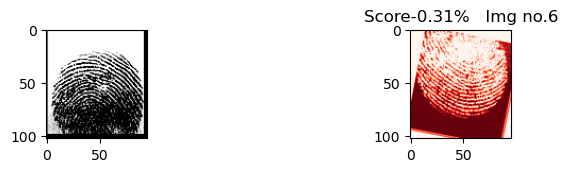

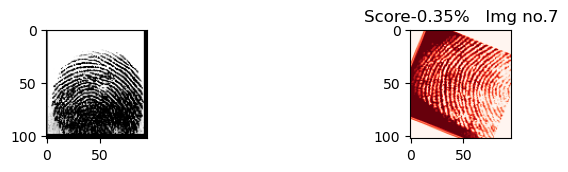

In [15]:
rnd_image = cv2.imread(os.path.join(folder, os.listdir(folder)[57]), 0)
rnd_image_clr = cv2.imread(os.path.join(folder, os.listdir(folder)[57]))
pair_image1 = np.expand_dims(rnd_image, axis=-1)
pair_image1 = np.expand_dims(pair_image1, axis=0)

height, width = rnd_image.shape[:2]
center = (width/2, height/2)

for index, name in enumerate(os.listdir(folder)[52:]):
    test_img = cv2.imread(os.path.join(folder, name), 0)
    test_img_clr = cv2.imread(os.path.join(folder, name))
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(360), scale=1)
    test_img = cv2.warpAffine(src=test_img, M=rotate_matrix, dsize=(width, height))
    test_img_clr = cv2.warpAffine(src=test_img_clr, M=rotate_matrix, dsize=(width, height))
    pair_image2 = np.expand_dims(test_img, axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    
    if name==os.listdir(folder)[57]: 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
    
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
    plt.imshow(rnd_image_clr ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(prediction)+str(index))
    plt.imshow(cv2.cvtColor(test_img_clr, cv2.COLOR_BGR2GRAY),cmap=c_map)

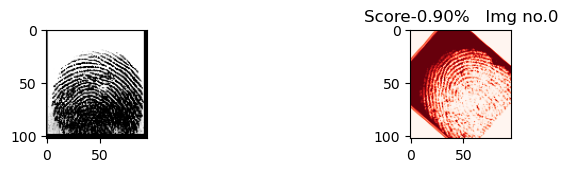

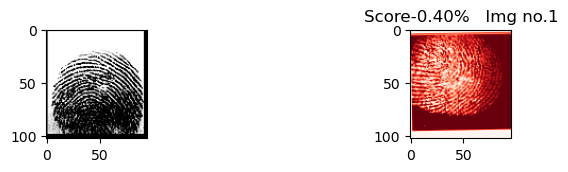

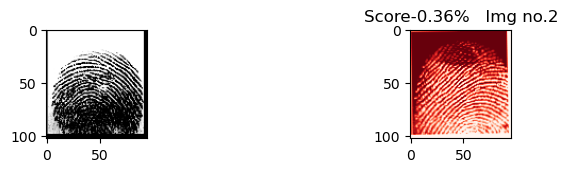

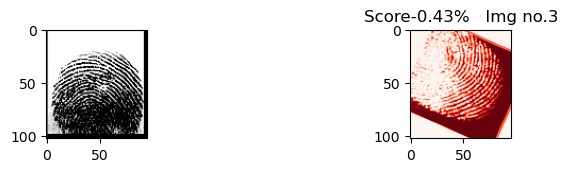

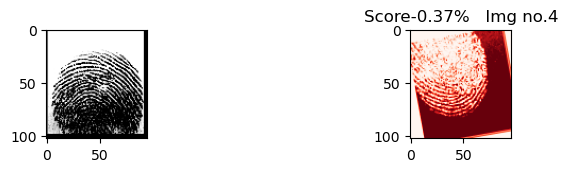

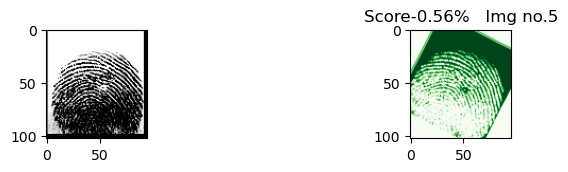

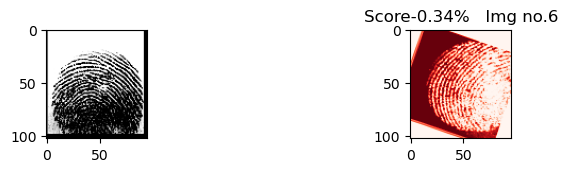

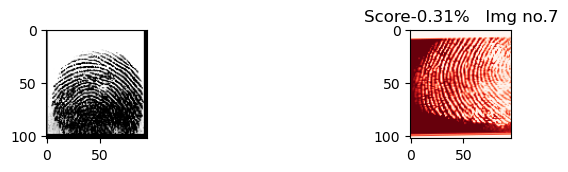

In [16]:
rnd_image = cv2.imread(os.path.join(folder, os.listdir(folder)[57]), 0)
rnd_image_clr = cv2.imread(os.path.join(folder, os.listdir(folder)[57]))
pair_image1 = np.expand_dims(rnd_image, axis=-1)
pair_image1 = np.expand_dims(pair_image1, axis=0)

height, width = rnd_image.shape[:2]
center = (width/2, height/2)

for index, name in enumerate(os.listdir(folder)[52:]):
    test_img = cv2.imread(os.path.join(folder, name), 0)
    test_img_clr = cv2.imread(os.path.join(folder, name))
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(360), scale=1)
    test_img = cv2.warpAffine(src=test_img, M=rotate_matrix, dsize=(width, height))
    test_img_clr = cv2.warpAffine(src=test_img_clr, M=rotate_matrix, dsize=(width, height))
    pair_image2 = np.expand_dims(test_img, axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    
    if name==os.listdir(folder)[57]: 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
    
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
    plt.imshow(rnd_image_clr ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(prediction)+str(index))
    plt.imshow(cv2.cvtColor(test_img_clr, cv2.COLOR_BGR2GRAY),cmap=c_map)

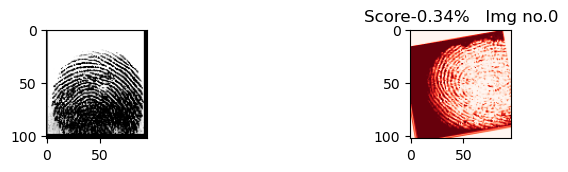

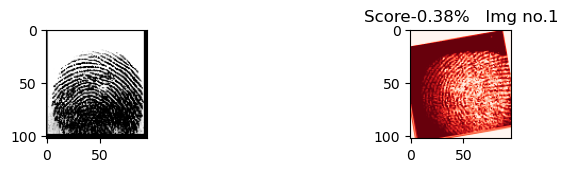

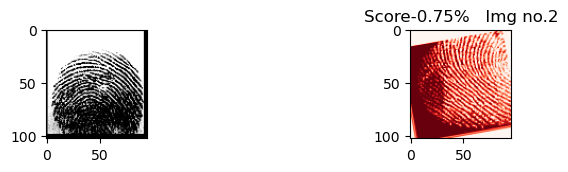

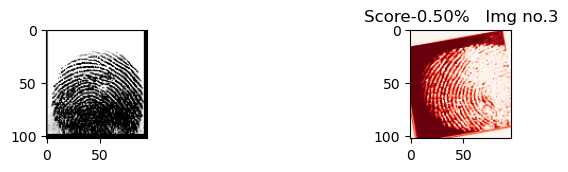

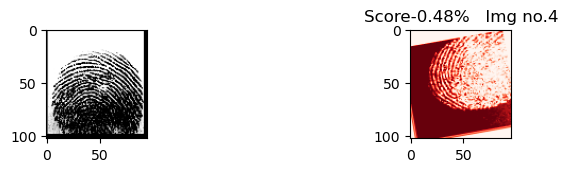

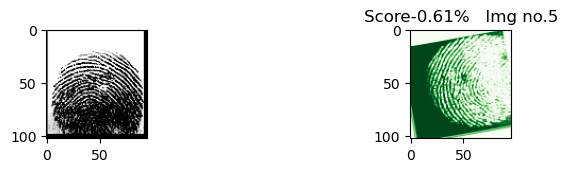

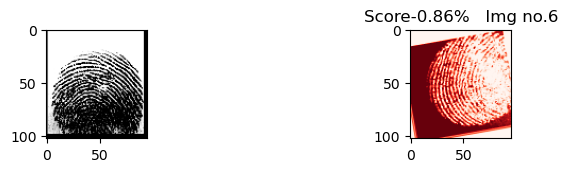

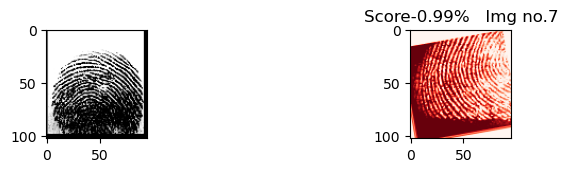

In [26]:
rnd_image = cv2.imread(os.path.join(folder, os.listdir(folder)[57]), 0)
rnd_image_clr = cv2.imread(os.path.join(folder, os.listdir(folder)[57]))
pair_image1 = np.expand_dims(rnd_image, axis=-1)
pair_image1 = np.expand_dims(pair_image1, axis=0)

height, width = rnd_image.shape[:2]
center = (width/2, height/2)

for index, name in enumerate(os.listdir(folder)[52:]):
    test_img = cv2.imread(os.path.join(folder, name), 0)
    test_img_clr = cv2.imread(os.path.join(folder, name))
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=100, scale=1)
    test_img = cv2.warpAffine(src=test_img, M=rotate_matrix, dsize=(width, height))
    test_img_clr = cv2.warpAffine(src=test_img_clr, M=rotate_matrix, dsize=(width, height))
    pair_image2 = np.expand_dims(test_img, axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    
    if name==os.listdir(folder)[57]: 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
    
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
    plt.imshow(rnd_image_clr ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(prediction)+str(index))
    plt.imshow(cv2.cvtColor(test_img_clr, cv2.COLOR_BGR2GRAY),cmap=c_map)

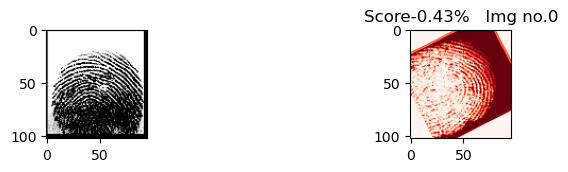

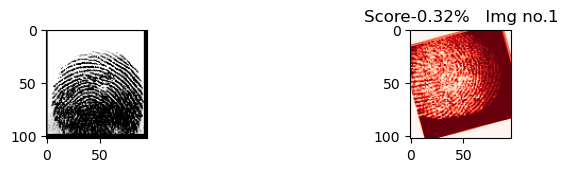

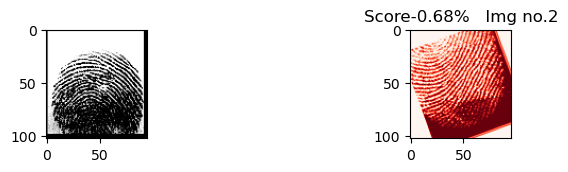

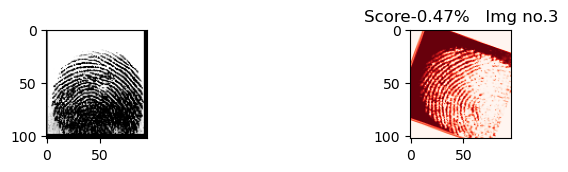

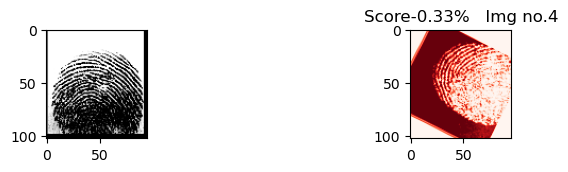

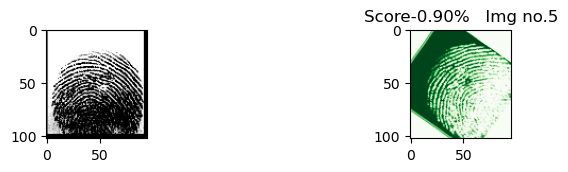

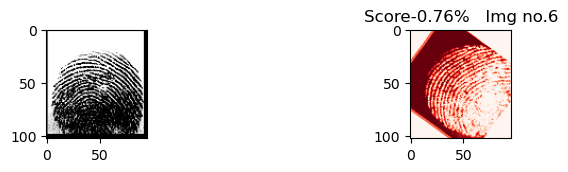

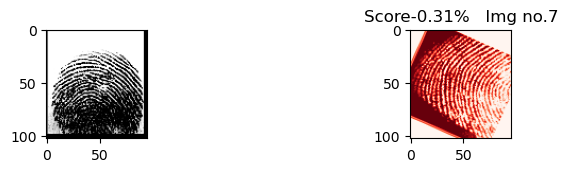

In [27]:
rnd_image = cv2.imread(os.path.join(folder, os.listdir(folder)[57]), 0)
rnd_image_clr = cv2.imread(os.path.join(folder, os.listdir(folder)[57]))
pair_image1 = np.expand_dims(rnd_image, axis=-1)
pair_image1 = np.expand_dims(pair_image1, axis=0)

height, width = rnd_image.shape[:2]
center = (width/2, height/2)

for index, name in enumerate(os.listdir(folder)[52:]):
    test_img = cv2.imread(os.path.join(folder, name), 0)
    test_img_clr = cv2.imread(os.path.join(folder, name))
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(360), scale=1)
    test_img = cv2.warpAffine(src=test_img, M=rotate_matrix, dsize=(width, height))
    test_img_clr = cv2.warpAffine(src=test_img_clr, M=rotate_matrix, dsize=(width, height))
    pair_image2 = np.expand_dims(test_img, axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    
    if name==os.listdir(folder)[57]: 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
    
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
    plt.imshow(rnd_image_clr ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(prediction)+str(index))
    plt.imshow(cv2.cvtColor(test_img_clr, cv2.COLOR_BGR2GRAY),cmap=c_map)

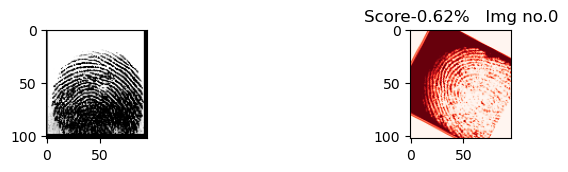

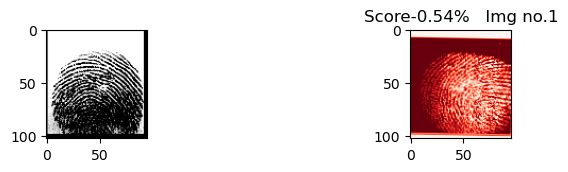

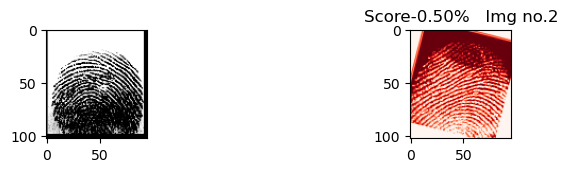

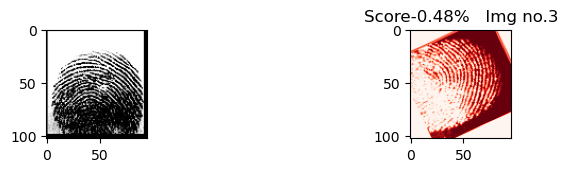

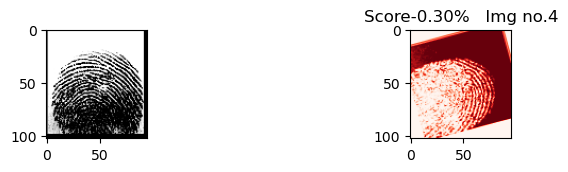

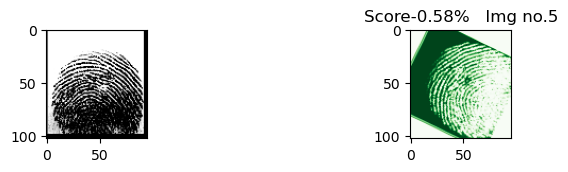

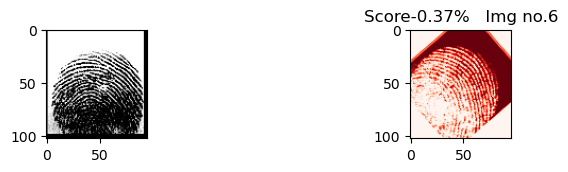

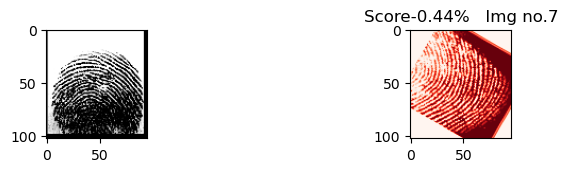

In [28]:
rnd_image = cv2.imread(os.path.join(folder, os.listdir(folder)[57]), 0)
rnd_image_clr = cv2.imread(os.path.join(folder, os.listdir(folder)[57]))
pair_image1 = np.expand_dims(rnd_image, axis=-1)
pair_image1 = np.expand_dims(pair_image1, axis=0)

height, width = rnd_image.shape[:2]
center = (width/2, height/2)

for index, name in enumerate(os.listdir(folder)[52:]):
    test_img = cv2.imread(os.path.join(folder, name), 0)
    test_img_clr = cv2.imread(os.path.join(folder, name))
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(360), scale=1)
    test_img = cv2.warpAffine(src=test_img, M=rotate_matrix, dsize=(width, height))
    test_img_clr = cv2.warpAffine(src=test_img_clr, M=rotate_matrix, dsize=(width, height))
    pair_image2 = np.expand_dims(test_img, axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    
    if name==os.listdir(folder)[57]: 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
    
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
    plt.imshow(rnd_image_clr ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(prediction)+str(index))
    plt.imshow(cv2.cvtColor(test_img_clr, cv2.COLOR_BGR2GRAY),cmap=c_map)